# Grover's Algorithm: Single Marked Element

This notebook demonstrates Grover's search algorithm to find a single marked item within an unsorted database using quantum computation.

- We construct the Grover oracle for any given target.
- We implement the core Grover iteration (oracle + diffusion).
- The algorithm is tested on a randomly chosen target.


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import math

from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator


## Grover Oracle

The oracle flips the phase of the computational basis state corresponding to the target index $j$.
It uses multi-controlled-X (Toffoli) and Z gates to accomplish this.


In [19]:
def grover_oracle(j: int, n: int):
    
    j_bin = format(j, f'0{n}b')  # Target index as n-bit binary string

    qc = QuantumCircuit(n)
    # Step 1: Apply X to qubits where j_bin is '0'
    for i, bit in enumerate(reversed(j_bin)):
        if bit == '0':
            qc.x(i)

    # Step 2: Multi-controlled Z
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)

    # Step 3: Undo X gates
    for i, bit in enumerate(reversed(j_bin)):
        if bit == '0':
            qc.x(i)

    qc.name = f"U_f (target = {j})"
    return qc


## Grover Iteration

Each Grover iteration consists of:
1. Applying the oracle for the marked state.
2. Applying the "diffusion operator" (inversion about the mean), implemented as an oracle for the all-zeros state and Hadamard gates.


In [20]:
def grover_operation(qc: QuantumCircuit, j: int, r: int):

    n = qc.num_qubits
    Uf = grover_oracle(j, n)      # Oracle for marked item
    U0 = grover_oracle(0, n)      # Oracle for |0...0> state (diffusion)

    for _ in range(r):
        qc.append(Uf, range(n))
        qc.h(range(n))
        qc.append(U0, range(n))
        qc.h(range(n))
        qc.barrier()


## Grover Algorithm

Prepares the quantum register, applies initial superposition, runs optimal number of Grover iterations, and measures the result.


In [21]:
def grover_algorithm(qc: QuantumCircuit, j: int):

    n = qc.num_qubits
    qc.h(range(n))  # Step 1: Uniform superposition

    # Step 2: Optimal number of Grover iterations
    r = int(np.trunc(np.pi / 4 * 2**(n / 2)))
    print(f"Number of Grover iterations: r = {r}")

    grover_operation(qc, j, r)
    qc.measure_all()


## Run and Visualize

Run Grover's algorithm on a random target and visualize the measurement outcomes.


Number of Grover iterations: r = 6


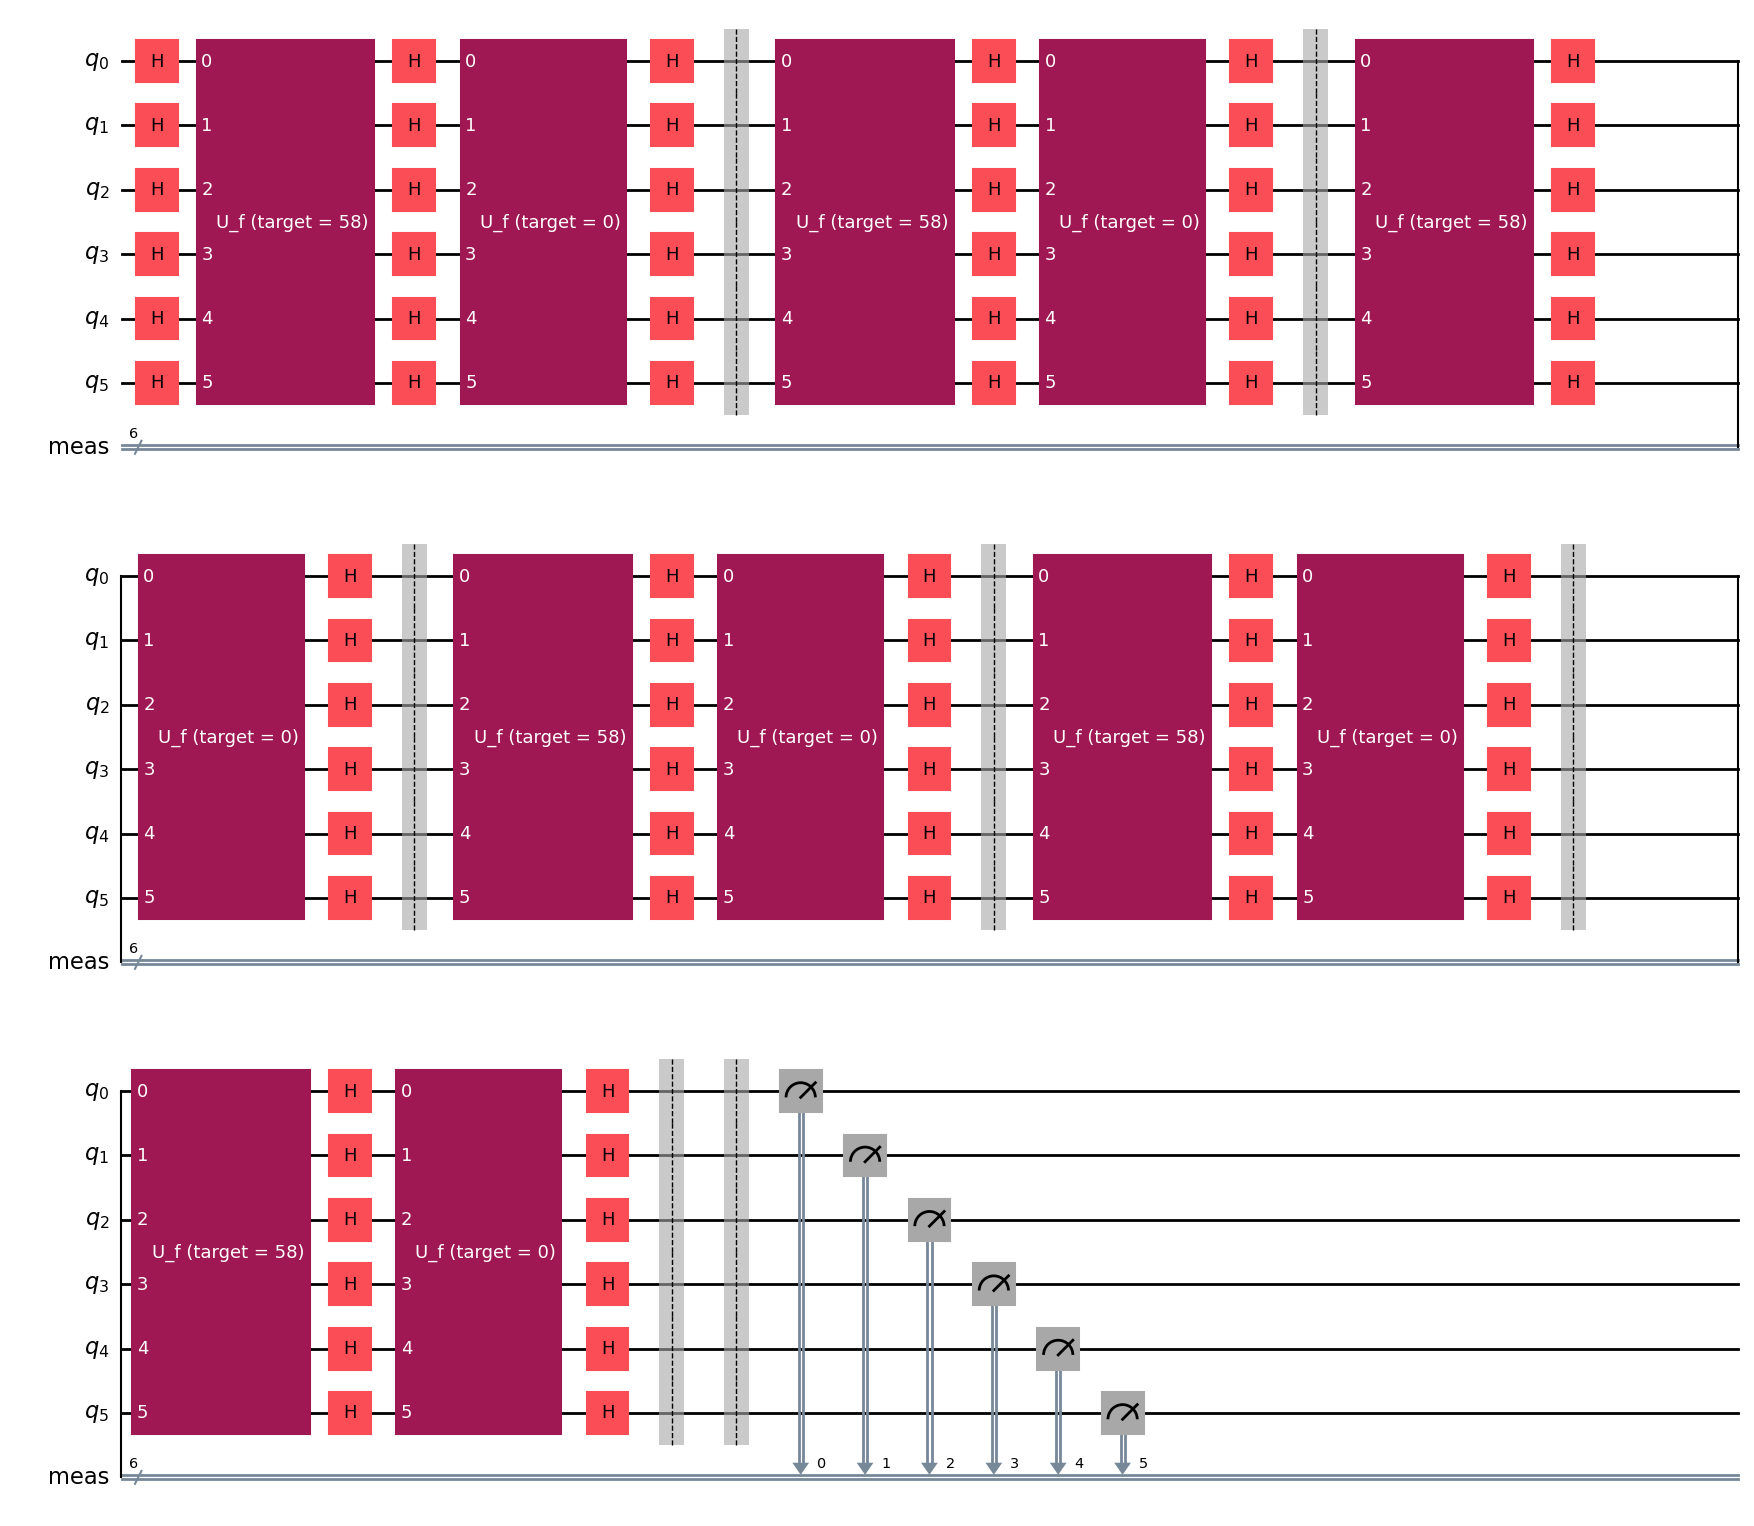

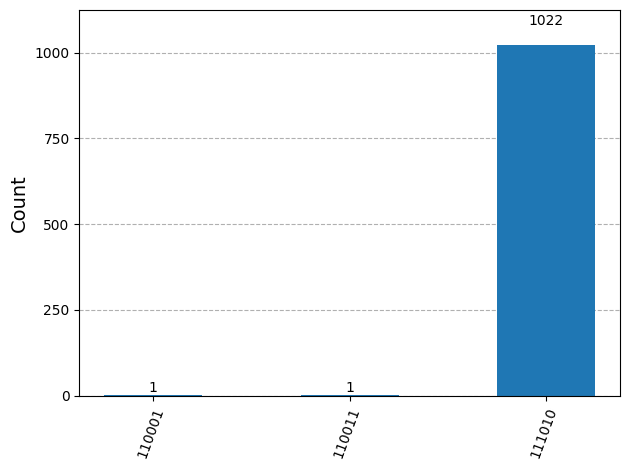

Grover's guess: 58, Real target: 58


In [22]:
# Number of qubits
n = 6

# Randomly select the target index j
j = np.random.randint(0, 2**n - 1)

# Initialize quantum circuit
qc = QuantumCircuit(n)

# Build the circuit of the Grover's algorithm
grover_algorithm(qc, j)

# Display the circuit
display(qc.draw('mpl'))

# Simulate using Aer (noiseless)
qc_transpiled = transpile(qc, backend=AerSimulator())
result = AerSimulator().run(qc_transpiled).result()
statistics = result.get_counts()

# Plot histogram of outcomes
display(plot_histogram(statistics))

# Extract the bitstring with the highest count
most_common_bitstring = max(statistics, key=statistics.get)
j_found = int(most_common_bitstring, 2)

print(f"Grover's guess: {j_found}, Real target: {j}")
